# Data science 3 - Supervised final assignment
### Lecturer : Bart Bernard
### Authur: Milad Toufani   -   Student number: 437689

# Frame the problem

I want to create a model for prediction of Parkinson disease base on the given features

In [41]:
# Import packages
# Add libriries which used in my assignment
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ShuffleSplit
# Ensemble learning
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier


In [22]:
# Function to evaluate
def evaluate(y_test, y_pred, X_test, clf):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
         
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(30, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="validation data")
    plt.legend(loc="upper right", fontsize=10)   
    plt.xlabel("Training set size", fontsize=10) 
    plt.ylabel("RMSE", fontsize=10)     
    # compare accuracy train versus test to access overfit 
    print(f'test  acc: {model.score(X_val, y_val)}')
    print(f'train acc: {model.score(X_train, y_train)}')

# Function for reading csv files
def open_csv(input_file_name, skiprows=False, skiprow=0):
    """
    This function will open a .CSV file
    input:  - covid information in .CSV format
            - choose to skip rows (default = false)
            - How many rows to skip
    output: Dataframe
    """
    try:
        if skiprows is True:
            dataframe = pd.read_csv(input_file_name, skiprows=skiprow)
        else:
            dataframe = pd.read_csv(input_file_name, skiprows=0)
        return dataframe
    except FileNotFoundError:
        print('error, this file does not exist. please specify a .CSV file')

# Load data

In [23]:
# Calling the function and create a dataframe
parkinson_df = open_csv('parkinsons.data')

# Inspect the data and Prepare data

In [24]:
# Check the shape of the dataset
print(f"The shape of dataset is: {parkinson_df.shape}")
# Check if the dataset has NA data
print(f"Number of N/A value in dataframe: {parkinson_df.isnull().sum().sum()}")
# Check the type of columns
print(f"\nType of columns:\n {parkinson_df.dtypes}")

The shape of dataset is: (195, 24)
Number of N/A value in dataframe: 0

Type of columns:
 name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object


In [25]:
# Check the values for observation and see if it needs to be normalized
parkinson_df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [26]:
# checking whether there is strange data in the diagnostics (the y-vector)
parkinson_df['status'].unique()

array([1, 0], dtype=int64)

In [27]:
# count number of observations in each class
Parkinsons , healthy = parkinson_df['status'].value_counts()
print(f"Number of patients labeled Parkinson's: {Parkinsons}")
print(f"Number of patients labeled healthy: {healthy}\n")
print(f"percentage of patients labeled Parkinson's: {round(Parkinsons / len(parkinson_df) * 100, 2)}%")
print(f"percentage of patients labeled healthy: {round(healthy / len(parkinson_df) * 100, 2)}%")

Number of patients labeled Parkinson's: 147
Number of patients labeled healthy: 48

percentage of patients labeled Parkinson's: 75.38%
percentage of patients labeled healthy: 24.62%


In [28]:
#Checking the status column
parkinson_df.status.unique()

array([1, 0], dtype=int64)

<AxesSubplot:>

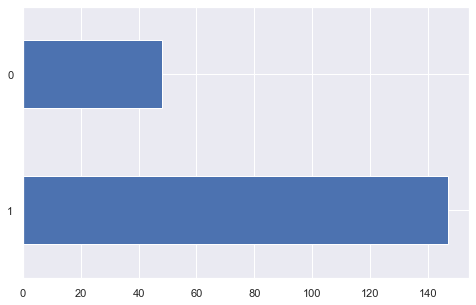

In [29]:
# Check de class variabele 
plt.rcParams["figure.figsize"] = (8,5)
parkinson_df.status.value_counts().plot(kind='barh')

# Split data

In [30]:
# Plot the pairplot 
cols = ['status',
        'MDVP:Fo(Hz)', 
        'MDVP:Fhi(Hz)', 
        'MDVP:Flo(Hz)', 
        'MDVP:Jitter(%)', 
        'MDVP:Jitter(Abs)', 
        'MDVP:RAP', 
        'MDVP:PPQ',
        'Jitter:DDP', 
        'MDVP:Shimmer', 
        'MDVP:Shimmer(dB)',
        'Shimmer:APQ3', 
        'Shimmer:APQ5', 
        'MDVP:APQ', 
        'Shimmer:DDA', 
        'NHR',
        'RPDE',
        'DFA', 
        'spread1', 
        'spread2', 
        'D2', 
        'PPE',
       ]

#sns.pairplot(data=parkinson_df[cols], hue='status', palette='RdBu')

In [31]:
"""
As I can see the there are some features that can be better choose for classification but now I'm not sure if
reduction od dimontions helps me to makea better model or not. We'll findout..
Also about the diagonal plots we can see that there are some features which show they can be better features
to predict our model
"""

"\nAs I can see the there are some features that can be better choose for classification but now I'm not sure if\nreduction od dimontions helps me to makea better model or not. We'll findout..\nAlso about the diagonal plots we can see that there are some features which show they can be better features\nto predict our model\n"

In [32]:
park_cor =  parkinson_df[cols].corr()

<AxesSubplot:>

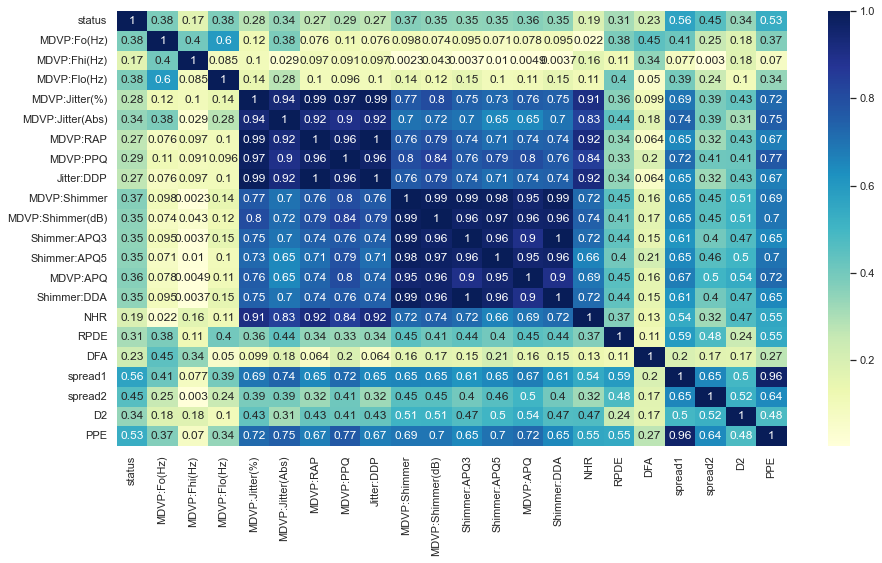

In [33]:
# create a correlation matrix
c = parkinson_df[cols].corr().abs()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(c, annot=True, cmap="YlGnBu")

In [34]:
"""
I'm trying to find the most feature correlation with status column which specify healthy and people who suffering from 
Parkinson. But as I can see there is not much correlation we can find between them. Just Spread1 and PPE feature has 
above 0.50 correlation
Also I can interprate that we can do dimention reduction for some features. I am checking that in below code
"""

"\nI'm trying to find the most feature correlation with status column which specify healthy and people who suffering from \nParkinson. But as I can see there is not much correlation we can find between them. Just Spread1 and PPE feature has \nabove 0.50 correlation\nAlso I can interprate that we can do dimention reduction for some features. I am checking that in below code\n"

In [35]:
for x in range(len(park_cor.columns)):
    park_cor.iloc[x,x] = 0.0

park_cor.abs().max()

status              0.564838
MDVP:Fo(Hz)         0.596546
MDVP:Fhi(Hz)        0.400985
MDVP:Flo(Hz)        0.596546
MDVP:Jitter(%)      0.990276
MDVP:Jitter(Abs)    0.935714
MDVP:RAP            1.000000
MDVP:PPQ            0.974256
Jitter:DDP          1.000000
MDVP:Shimmer        0.987626
MDVP:Shimmer(dB)    0.987258
Shimmer:APQ3        1.000000
Shimmer:APQ5        0.982835
MDVP:APQ            0.960977
Shimmer:DDA         1.000000
NHR                 0.919548
RPDE                0.591117
DFA                 0.446013
spread1             0.962435
spread2             0.652358
D2                  0.536869
PPE                 0.962435
dtype: float64

In [36]:
park_cor.abs().idxmax()

status                       spread1
MDVP:Fo(Hz)             MDVP:Flo(Hz)
MDVP:Fhi(Hz)             MDVP:Fo(Hz)
MDVP:Flo(Hz)             MDVP:Fo(Hz)
MDVP:Jitter(%)            Jitter:DDP
MDVP:Jitter(Abs)      MDVP:Jitter(%)
MDVP:RAP                  Jitter:DDP
MDVP:PPQ              MDVP:Jitter(%)
Jitter:DDP                  MDVP:RAP
MDVP:Shimmer             Shimmer:DDA
MDVP:Shimmer(dB)        MDVP:Shimmer
Shimmer:APQ3             Shimmer:DDA
Shimmer:APQ5            MDVP:Shimmer
MDVP:APQ            MDVP:Shimmer(dB)
Shimmer:DDA             Shimmer:APQ3
NHR                       Jitter:DDP
RPDE                         spread1
DFA                      MDVP:Fo(Hz)
spread1                          PPE
spread2                      spread1
D2                          MDVP:APQ
PPE                          spread1
dtype: object

In [37]:
# I choose these features because they have the most corelation with the status 
cols =  ['spread1', 'spread2', 'PPE']

# Train model

In [38]:
y = np.array(parkinson_df['status'])
X = np.array(parkinson_df[cols])
X.shape


(195, 3)

In [39]:
# We need to normalize the data 
# Normalize
from sklearn.preprocessing import StandardScaler

def normalize(X):
    scalar = StandardScaler()
    scalar = scalar.fit(X)
    X = scalar.transform(X)
    return X

X = normalize(X)

# Use model to predict and Evaluate model

## Logistic

In [42]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

In [43]:
# evaluation
y_pred = lg.predict(X_test)
evaluate(y_test, y_pred, X_test, lg)

[[11  4]
 [ 1 43]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.91      0.98      0.95        44

    accuracy                           0.92        59
   macro avg       0.92      0.86      0.88        59
weighted avg       0.92      0.92      0.91        59



test  acc: 0.9152542372881356
train acc: 0.8308823529411765


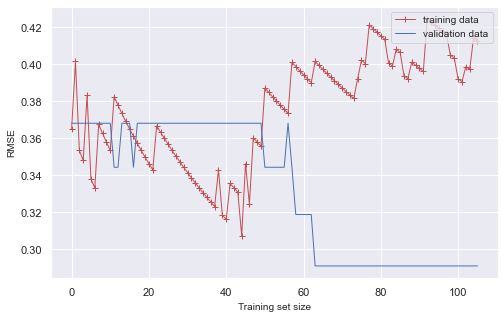

In [47]:
plt.rcParams["figure.figsize"] = (8,5)
plot_learning_curves(lg, X_train, y_train, X_test, y_test)

## Decision Tree

In [48]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [49]:
y_pred = dt.predict(X_test)
evaluate(y_test, y_pred, X_test, dt)

[[11  4]
 [ 3 41]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.91      0.93      0.92        44

    accuracy                           0.88        59
   macro avg       0.85      0.83      0.84        59
weighted avg       0.88      0.88      0.88        59



test  acc: 0.8813559322033898
train acc: 1.0


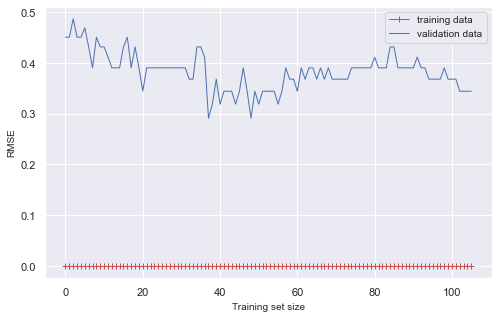

In [50]:
plot_learning_curves(dt, X_train, y_train, X_test, y_test)

## SVM

In [51]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC()

[[ 9  6]
 [ 1 43]]
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.88      0.98      0.92        44

    accuracy                           0.88        59
   macro avg       0.89      0.79      0.82        59
weighted avg       0.88      0.88      0.87        59

test  acc: 0.8813559322033898
train acc: 0.8308823529411765


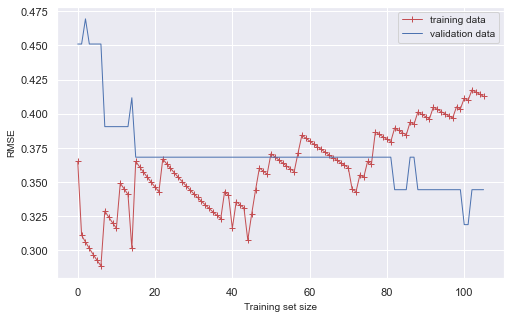

In [52]:
y_pred = svm.predict(X_test)
evaluate(y_test, y_pred, X_test, svm)
plot_learning_curves(svm, X_train, y_train, X_test, y_test)

## Naive Bayes

In [53]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

[[12  3]
 [ 7 37]]
              precision    recall  f1-score   support

           0       0.63      0.80      0.71        15
           1       0.93      0.84      0.88        44

    accuracy                           0.83        59
   macro avg       0.78      0.82      0.79        59
weighted avg       0.85      0.83      0.84        59

test  acc: 0.8305084745762712
train acc: 0.7867647058823529


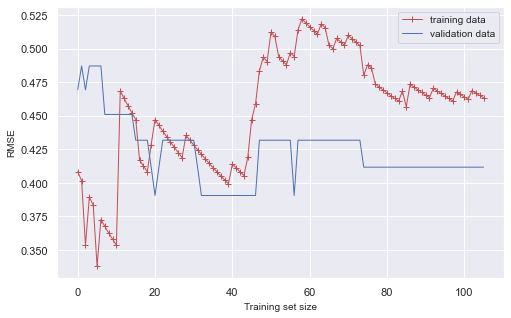

In [54]:
y_pred = gnb.predict(X_test)
evaluate(y_test, y_pred, X_test, gnb)
plot_learning_curves(gnb, X_train, y_train, X_test, y_test)

In [55]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

[[10  5]
 [ 1 43]]
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.90      0.98      0.93        44

    accuracy                           0.90        59
   macro avg       0.90      0.82      0.85        59
weighted avg       0.90      0.90      0.89        59

test  acc: 0.8813559322033898
train acc: 0.9852941176470589


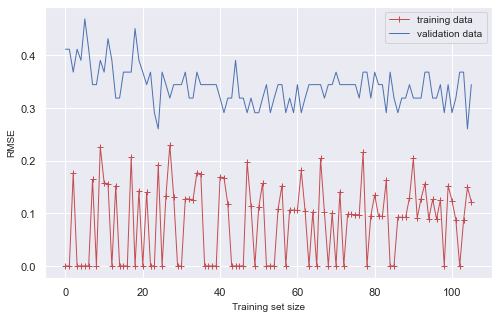

In [56]:
y_pred = rf.predict(X_test)
evaluate(y_test, y_pred, X_test, rf)
plot_learning_curves(rf, X_train, y_train, X_test, y_test)

## Bagging with Decicion Tree classifier

In [57]:
bg = BaggingClassifier(DecisionTreeClassifier(), max_features = 1.0, max_samples = 0.5) 
bg.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5)

[[12  3]
 [ 3 41]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.93      0.93      0.93        44

    accuracy                           0.90        59
   macro avg       0.87      0.87      0.87        59
weighted avg       0.90      0.90      0.90        59

test  acc: 0.9322033898305084
train acc: 0.9411764705882353


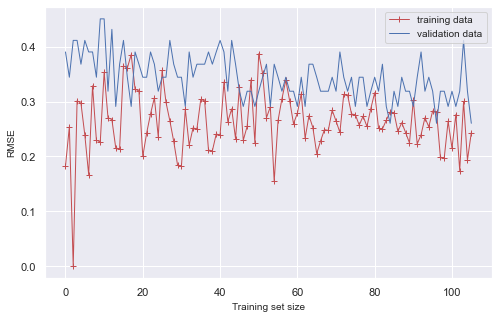

In [58]:
y_pred = bg.predict(X_test)
evaluate(y_test, y_pred, X_test, bg)
plot_learning_curves(bg, X_train, y_train, X_test, y_test)

## Boosting

In [59]:
adb = AdaBoostClassifier(LogisticRegression(), n_estimators = 10, learning_rate = 1)
adb.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1,
                   n_estimators=10)

[[11  4]
 [ 1 43]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.91      0.98      0.95        44

    accuracy                           0.92        59
   macro avg       0.92      0.86      0.88        59
weighted avg       0.92      0.92      0.91        59

test  acc: 0.9152542372881356
train acc: 0.8382352941176471


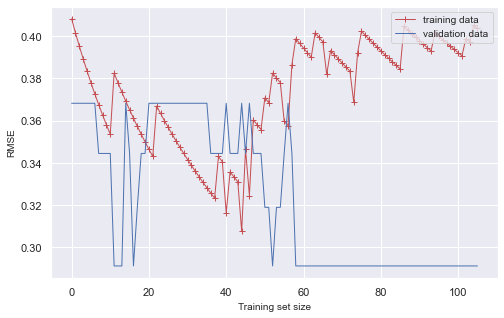

In [60]:
y_pred = adb.predict(X_test)
evaluate(y_test, y_pred, X_test, adb)
plot_learning_curves(adb, X_train, y_train, X_test, y_test)

## Voting classifier

In [61]:
evc = VotingClassifier(estimators = [('dt', dt), ('lg',lg), ('svm', svm)], voting = 'hard')
evc.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('lg', LogisticRegression()), ('svm', SVC())])

[[11  4]
 [ 1 43]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.91      0.98      0.95        44

    accuracy                           0.92        59
   macro avg       0.92      0.86      0.88        59
weighted avg       0.92      0.92      0.91        59

test  acc: 0.9152542372881356
train acc: 0.8455882352941176


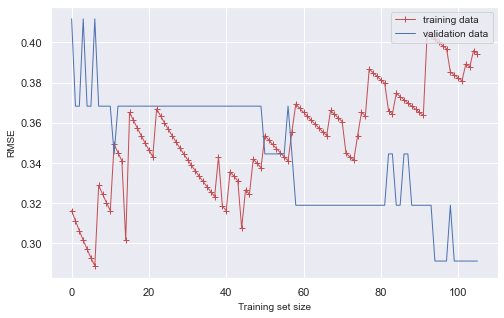

In [62]:
y_pred = evc.predict(X_test)
evaluate(y_test, y_pred, X_test, evc)
plot_learning_curves(evc, X_train, y_train, X_test, y_test)